In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
import cv2
import copy

In [ ]:
!wget 'http://files.fast.ai/data/cifar10.tgz'
!tar -xf cifar10.tgz

--2020-06-12 10:30:56--  http://files.fast.ai/data/cifar10.tgz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168168549 (160M) [application/x-gtar-compressed]
Saving to: ‘cifar10.tgz’

cifar10.tgz         100%[===================>] 160.38M  43.0MB/s    in 4.2s    

2020-06-12 10:31:00 (38.4 MB/s) - ‘cifar10.tgz’ saved [168168549/168168549]



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
data_dir = '/content/cifar10'

print(os.listdir(data_dir))
classes = sorted(os.listdir(data_dir + "/train"))
print(classes)

['labels.txt', 'train', 'test']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
input_size = 224

In [ ]:
data_transform = transforms.Compose([transforms.Resize(input_size),transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

dataset = ImageFolder(data_dir+'/train',   transform=data_transform)

In [ ]:
def split_indices(n, val_pct, seed):
    # Determine size of validation set
    n_val = int(val_pct*n)
    # Set the random seed (for reproducibility)
    np.random.seed(seed)
    # Create random permutation of 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [ ]:
val_pct = 0.2
rand_seed = 42

train_indices, val_indices = split_indices(len(dataset), val_pct, rand_seed)
print(len(train_indices), len(val_indices))
print('Sample validation indices: ', val_indices[:10])

40000 10000
Sample validation indices:  [33553  9427   199 12447 39489 42724 10822 49498  4144 36958]


In [ ]:
batch_size=128

# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset, 
                      batch_size, 
                      sampler=train_sampler,num_workers=2)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset,
                    batch_size, 
                    sampler=val_sampler,num_workers=2)

In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 50000
    Root location: /content/cifar10/train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  airplane


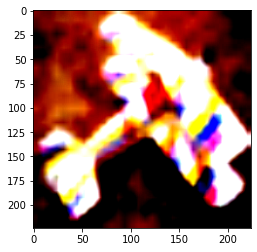

In [ ]:
img,label = dataset[50]
print("Label: ",classes[label])
plt.imshow(np.array(img.squeeze().permute(1,2,0)))


In [ ]:
model = models.alexnet(pretrained=True,progress=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
#Freezing Layers
for param in model.parameters():
  param.requires_grad = False

In [ ]:
num_in_features = model.classifier[6].in_features
num_in_features

4096

In [ ]:
hidden_size = 2752
num_classes = len(classes)

In [ ]:
fc_layers = nn.Sequential(
    nn.Linear(num_in_features,hidden_size),
    nn.ReLU(inplace=True),
    nn.Linear(hidden_size,num_classes)
)

In [ ]:
# Adding 2 layer NN to AlexNet model's classifier layer
model.classifier[6] = fc_layers


In [ ]:
#Updated Model
to_device(model,device)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# params_update  = model.parameters()
params_to_update = []
print('Parameters to update for Feature extraction: ')
for name,param in model.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)
    print(name)

Parameters to update for Feature extraction: 
classifier.6.0.weight
classifier.6.0.bias
classifier.6.2.weight
classifier.6.2.bias


In [ ]:
opt = torch.optim.SGD(params_to_update, lr=0.005, momentum=0.9)

In [ ]:
def accuracy(outputs,labels):
  _,preds =  torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [ ]:
# def validation_step(loss,acc):
#   return {'val_loss' : loss, 'val_acc' : acc }

In [ ]:
def validation_epoch_end(outputs):
  batch_losses = [x['val_loss'] for x in outputs]
  epoch_loss = torch.stack(batch_losses).mean()
  batch_accs = [x['val_acc'] for x in outputs]
  epoch_acc = torch.stack(batch_accs).mean()
  return {'val_loss' : epoch_loss.item(), 'val_acc' : epoch_acc.item() }
    
def epoch_end(epoch, result):
  print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
def train_model(model,train_loader,valid_loader,criterion,epochs,opt_fn):
  history = []  

  best_model_params = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(epochs):
    epoch_stats = []
    #For Training
    model.train()
    # curr_loss = 0.0
    # curr_acc = 0
    for batch in train_loader:
      batch = to_device(batch,device)
      images,labels = batch
      with torch.set_grad_enabled(True):
        opt.zero_grad()

        outputs = model(images)
        loss = criterion(outputs,labels)
        # curr_acc = accuracy(outputs,labels)
        # curr_loss = loss.item()
        loss.backward()
        opt.step()
    
    #For validation
    model.eval()
    for batch in valid_loader:
      batch = to_device(batch,device)
      images,labels = batch
      with torch.no_grad():
        outputs = model(images)
        loss = criterion(outputs,labels)
        acc = accuracy(outputs,labels)
        epoch_stats.append({'val_loss' : loss, 'val_acc' : acc })

    result = validation_epoch_end(epoch_stats)

    if best_acc < result['val_acc']:
      best_model_params = copy.deepcopy(model.state_dict())
      best_acc = result['val_acc']

    if(epoch+1)%1==0:
      epoch_end(epoch+1,result)
      print('Best Validation Acc: {:.4f} '.format(best_acc))
      # print('\n')

    history.append(result)

  model.load_state_dict(best_model_params)
  return model, history    


In [ ]:
# Setup the loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
model,history = train_model(model,train_dl,val_dl,criterion,30,opt)

Epoch [1], val_loss: 0.5791, val_acc: 0.7988
Best Validation Acc: 0.7988 
Epoch [2], val_loss: 0.5408, val_acc: 0.8098
Best Validation Acc: 0.8098 
Epoch [3], val_loss: 0.5240, val_acc: 0.8154
Best Validation Acc: 0.8154 
Epoch [4], val_loss: 0.5080, val_acc: 0.8245
Best Validation Acc: 0.8245 
Epoch [5], val_loss: 0.5429, val_acc: 0.8107
Best Validation Acc: 0.8245 
Epoch [6], val_loss: 0.4813, val_acc: 0.8312
Best Validation Acc: 0.8312 
Epoch [7], val_loss: 0.5097, val_acc: 0.8199
Best Validation Acc: 0.8312 
Epoch [8], val_loss: 0.4825, val_acc: 0.8277
Best Validation Acc: 0.8312 
Epoch [9], val_loss: 0.4735, val_acc: 0.8320
Best Validation Acc: 0.8320 
Epoch [10], val_loss: 0.4731, val_acc: 0.8410
Best Validation Acc: 0.8410 
Epoch [11], val_loss: 0.4497, val_acc: 0.8466
Best Validation Acc: 0.8466 
Epoch [12], val_loss: 0.4766, val_acc: 0.8370
Best Validation Acc: 0.8466 
Epoch [13], val_loss: 0.4494, val_acc: 0.8412
Best Validation Acc: 0.8466 
Epoch [14], val_loss: 0.4576, val_

In [ ]:
torch.save(model.state_dict(),'cifar_alexnet.pth')

In [ ]:
test_dataset = ImageFolder(data_dir+'/test', transform=data_transform)

In [ ]:
test_dl = DataLoader(test_dataset, batch_size=256)

In [ ]:
def evaluate(model,test_loader,criterion):
#For validation
  model.eval()
  epoch_stats = []
  for batch in test_loader:
   batch = to_device(batch,device)
   images,labels = batch
   with torch.no_grad():
     outputs = model(images)
     loss = criterion(outputs,labels)
     acc = accuracy(outputs,labels)
     epoch_stats.append({'val_loss' : loss, 'val_acc' : acc })

  return validation_epoch_end(epoch_stats)


In [ ]:
test_result = evaluate(model,test_dl,criterion)

In [ ]:
print("test_loss: {:.4f}, test_acc: {:.4f}".format(test_result['val_loss'], test_result['val_acc']))

test_loss: 0.4570, test_acc: 0.8403
